# Boson Bunching

A prominent example of boson bunching is the Hong-Ou-Mandel effect, where the bunching of two photons arises from a destructive quantum interference between the trajectories where they both either cross a beam splitter or are reflected. This effect takes its roots in the indistinguishability of identical photons. You can read more about it [here](http://arxiv.org/abs/1711.00080) [1].
More generally one can send in $n$ photons into an optical interferometer via $m$ modes and one then measures in which modes the photons are ending up.
For the example discussed here there are 7 photons sent into 7 modes and we are interested in the probability that all 7 photons end up in the first two modes. The interferometer is described by an unitary matrix and the incoming photons can be fully indistiguishable, fully distinguishable or partially distiguishable.

## Introduction

The paper ["Boson bunching is not maximized by indistinguishable particles"](http://arxiv.org/abs/2203.01306) [2] shows that, unlike in the Hong-Ou-Mandel effect, bunching gets maximised with partialy distinguishable photons. This disproofs the following conjecture:
_________________________________________________________________________________________________________________________________________________________
##### Conjecture 1
(Generalized Bunching). Consider any input state of classically correlated photons. For any linear interferometer
$\hat{U}$ and any nontrivial subset $\mathcal{K}$ of output modes, the probability that all photons are found in $\mathcal{K}$ is maximal if the photons are (perfectly) indistinguishable. 
_________________________________________________________________________________________________________________________________________________________
Evidence for this conjecture was given [here](https://arxiv.org/abs/1509.01561) [3].

The probability for such a case is given by:
$$
P_n(S) = perm(H \odot S^T)
$$
where $n$ is the number of input photons, $S$ the distiguishability  matrix and $H$ a matrix which depends on $\hat{U}$ and $\mathcal{K}$. The symbol $\odot$ is the elementwise multiplication.

The distiguishability  matrix $S$ is defined by:
$$ S_{ij} = <i|j> $$ 
where $<i|$ is the photon in the $i^{th}$ input mode $S_{ij} = 1$ if $\text{photon}_i$ and $\text{photon}_j$ are indistiguishable and $0$ if $\text{photon}_i$ and $\text{photon}_j$ are fully distinguishable. So for fully indistinguishable photons, $S$ is the matrix with ones in all entries.

The matrix $H$ is defined by: 
$$
H_{ij} = \sum_{l\in\mathcal{K}} U^*_{li} U_{lj}
$$
with $i,j \in \{1, ... , n\}$ where $n$ is the number of input photons.
If we now compare the probability for fully indistinguishable photons to parially distinguishable photons we can rewrite conjecture 1 like this:
$$
perm(H) ≥ perm(H \odot S^T)
$$

This version of the conjecture has been proven wrong with a 7 by 7 counterexample by [Drury](https://journals.uwyo.edu/index.php/ela/article/view/1631/1631) [4].

In this notebook we are constructing an optical circuit based on this counter example and input the partially distinguishable photons to show that this indeed amplifies the bunching probability.



# Step 0
Setting up the required packages.

In [1]:
## Perceval 
import perceval as pcvl

## Other
import numpy as np
import math
import matplotlib.pyplot as plt

# Step 1
## Constructing the unitary matrix

The counter example to the conjecture is $H = A$ and $S^T = A^T$ with
$$A = M^{\dagger} M \text{ with }
M= \frac{1}{\sqrt{2}} \begin{pmatrix}
\sqrt{2} & 0 & 1 & 1 & 1 & 1 & 1\\
0 & \sqrt{2} & 1 & \omega & \omega^2 & \omega^3 & \omega^4
\end{pmatrix} 
$$
and $\omega = exp(\frac{2*\pi *i}{5})$, the $5^{th}$ root of unitiy.

Thus we have to contruct the unitary circuit fom the definition of $H$. There are infinitly many such unitaries and we therefore generate a random one which returns $H=A$.

In [2]:
# number of input photons and modes (works for n ≥ 4) See [2] for the generalisation of the above to n photons.
n = 7
#definition of w as the (n-2)th root of unity
w = np.exp((2*math.pi*1j)/(n-2))

def CreateVectors(n,w):
    #first two orthonormal vectors from which the Unitary matrix for the circuit is built
    v1 = np.zeros(n,dtype = 'complex_')
    v1[0] = 1
    v1[1] = 0
    for i in range(2,n):
        v1[i] = 1/math.sqrt(2)

    v2 = np.zeros(n,dtype = 'complex_')
    v2[0] = 0
    v2[1] = 1
    for i in range(2,n):
        v2[i] = np.conj(w**(i-2))/math.sqrt(2)

    return v1, v2 # these are the complex conjugate of the first two rows of the matrix M for n=7

def normalize(vector):
    return vector / np.linalg.norm(vector)

def MakeUnitary(n, w):
    vector1, vector2 = CreateVectors(n,w)

    orthonormal_basis = [normalize(vector1), normalize(vector2)]
    for _ in range(n-2):
        random_vector = np.random.rand(n) +  1j*np.random.rand(n) # Create a random 7-dimensional complex vector
        # Subtract projections onto existing basis vectors to make it orthogonal
        for basis_vector in orthonormal_basis:
            random_vector -= np.vdot(basis_vector,random_vector) * basis_vector
            # Normalize the orthogonal vector to make it orthonormal
        orthonormal_basis.append(normalize(random_vector))
        # Define the unitary matrix from the calculated vectors
    mat = []
    for i in range(n):
        mat.append(orthonormal_basis[i])
    UnitaryMatrix = np.matrix(mat)

    return UnitaryMatrix

UnitaryMatrix = MakeUnitary(n, w)

# Step 2 
## Building the Circuit

Now that we have the unitary matrix we can use perceval to create a circuit from it. We do this by decomposing the unitary into Mach-Zender Interferometers. This gives us a 7 modes interferometer.

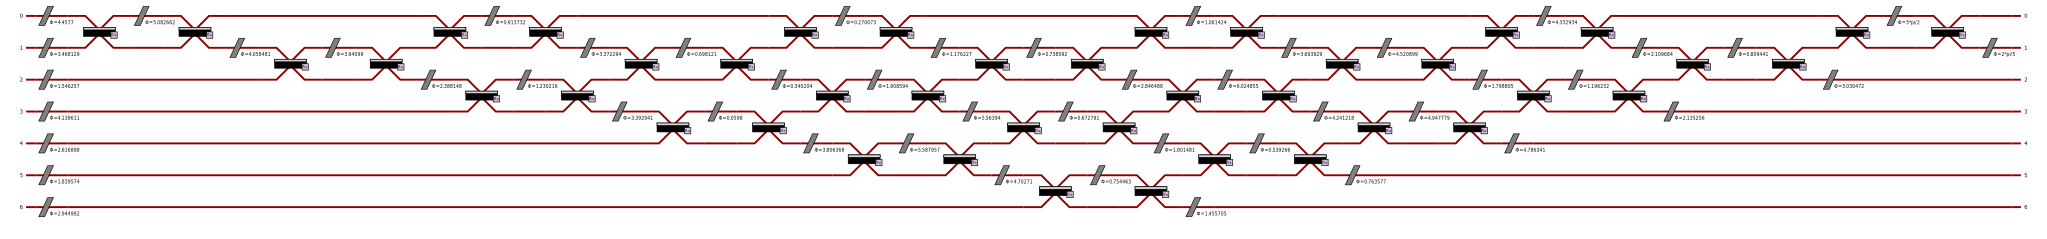

In [3]:
# building Mach-Zender Interferometer block of the circuit
mzi = (pcvl.BS() // (0, pcvl.PS(phi=pcvl.Parameter("φ_a")))
       // pcvl.BS() // (1, pcvl.PS(phi=pcvl.Parameter("φ_b"))))
# convert Unitary matrix into perceval languange
Unitary = pcvl.Matrix(UnitaryMatrix)
#create circuit
Circuit_Rand = pcvl.Circuit.decomposition(Unitary, mzi,
                                               phase_shifter_fn=pcvl.PS,
                                               shape="triangle")

pcvl.pdisplay(Circuit_Rand, recursive=True)

# Step 3 
## Inputing photons of different degrees of distinguishability

Now that we have the circuit which represents the correct unitary matrix and therefore the correct $H$ from the conjecture, we need to feed in the right photons following the distinguishability matrix $S=A$. In the [paper](http://arxiv.org/abs/2203.01306)[2] the input photons are described via polarization. In this simulation it is not specified how the photons are distinguishable. The first two photons are fully disinguishable. The other five photons are each a linear combination of the first two photons and form an equally spaced star shape when drawn on the Bloch sphere. 

Here one can see the two fully disinguishable photons with red arrows and the five linear combinations in the equator plane.

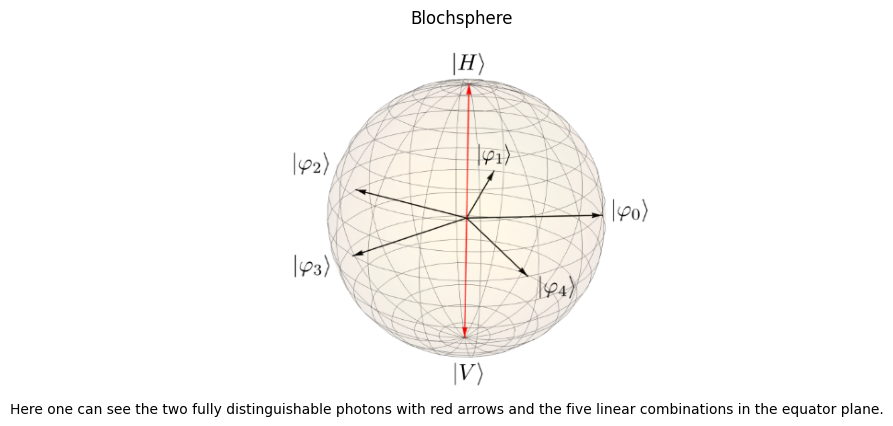

In [4]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
 
plt.title("Blochsphere")
plt.axis('off')

image = mpimg.imread("Blochsphere.png")
plt.imshow(image)
plt.text(200, 410, "Here one can see the two fully distinguishable photons with red arrows and the five linear combinations in the equator plane.", ha='center', va='center')
plt.show()


In [5]:
def Create_inputs(n,w):
    #make a list of fully distinguishable photons of the form |{a:i}> that means we give the photon an attribute a with value i 
    States_dist = []
    for i in range(1,n+1):
        x = "|{{a:{}}}>".format(i)
        States_dist.append(pcvl.StateVector(x))
    #make a list of all input photons which are superpositions of |{a:1}> and |{a:2}>
    States_par_dist = [States_dist[0], States_dist[1]] #start with the pure states |{a:1}> and |{a:2}>
    for i in range(2,n):
        x = States_par_dist[0] + w**(i-2) * States_par_dist[1] #add the states |{a:1}> + w^(i-2)|{a:2}>
        States_par_dist.append(x)
    #Input states
    #initialise the variables
    indisting_photons = [] 
    par_disting_photons = 1 
    disting_photons = 1 
    #fill the states
    for i in range(n):
        indisting_photons.append(1) # gives the state |1,1, ... , 1>
        par_disting_photons = par_disting_photons * States_par_dist[i]
        disting_photons = disting_photons * States_dist[i] # gives the state |{a:1},{a:2}, ... ,{a:n}> 
    return pcvl.BasicState(indisting_photons), par_disting_photons, disting_photons


input_indistinguishable, input_partiallydistinguishable, input_distinguishable = Create_inputs(n,w) #indistinguishable photons, partially distinguishable photons, fully distinguishable photons respectively 

To see if photon bunching gets amplified for partially distiguishable photons we need to compare it to the case of indistinguishable photons and for interest we are also comparing it to fully distinguishable photons. We are expecting that the probability for partially distinguishable photons will be highest followed by the indistiguishable photons and fully distinguishable photons having the lowest probability.

In [6]:
#simulating boson sampling
p = pcvl.Processor("SLOS")
p.set_circuit(Circuit_Rand)
s = pcvl.SimulatorFactory().build(p)

In [7]:
def CalcProb(disttype_input, n, Simulator):
    def Reverse(lst):
        new_lst = lst[::-1]
        return new_lst
    #initialize the probabilities
    Probability_photons = 0
    Probability_distribution_photons = []
    #summing over all cases where all photons end up in only two modes
    for i in range(math.ceil((n+1)/2)): # range over half the distribution because of symmetry
        p = Simulator.probability(disttype_input, pcvl.BasicState([i,n-i]+[0]* (n-2)))
        Probability_distribution_photons.append(p)
        Probability_photons += p
    X = []
    for i in range(math.ceil((n+1)/2), n+1):
        X.append(Probability_distribution_photons[i-math.ceil((n+1)/2)])
        Probability_photons += Probability_distribution_photons[i-math.ceil((n+1)/2)]
    Probability_distribution_photons = Probability_distribution_photons + Reverse(X)
    for i in range(n+1):
        if Probability_photons != 0:
            Probability_distribution_photons[i] = Probability_distribution_photons[i]/Probability_photons
    
    return Probability_distribution_photons, Probability_photons

# Save the Probabilities so we don't have to run the CalcProb function multiple times
Probdist_indist , Prob_indist = CalcProb(input_indistinguishable, n, s)
Probdist_fully , Prob_fully = CalcProb(input_distinguishable, n, s) # high runtime
Probdist_partial , Prob_partial = CalcProb(input_partiallydistinguishable, n, s) # high runtime


print("The probability for all {} {} photon ending up in the first two modes is: {:0.3f} %".format(n,"indistinguishable",Prob_indist*100))
print("The probability for all {} {} photon ending up in the first two modes is: {:0.3f} %".format(n,"distinguishable",Prob_fully*100))
print("The probability for all {} {} photon ending up in the first two modes is: {:0.3f} %".format(n,"partially distinguishable",Prob_partial*100))

The probability for all 7 indistinguishable photon ending up in the first two modes is: 0.699 %
The probability for all 7 distinguishable photon ending up in the first two modes is: 0.016 %
The probability for all 7 partially distinguishable photon ending up in the first two modes is: 0.751 %


From the results above we can clearly see that the implemented partial distiguishablity amplified the bunching probability from 0.699% to 0,751%. This however does not proof that our set up gives the maximum bunching probability. As it only disproofs the conjecture with a counter example.

# Step 4
## Plotting the results
The first plot shows two-mode bunching probabilities for the three different scenarios. Here we can see the results match our expectations.

The second plot shows the photon-number probability distribution for the first two output modes. The distributions are normalized, i.e., the probabilities are conditioned on events where all 7 photons end up in the first two modes (two-mode bunching events). This plot is interesting because it shows that the shape of the distribution of indistiguishable photons is very different to the shape of the distributions of partially and fully distinguishable photons.

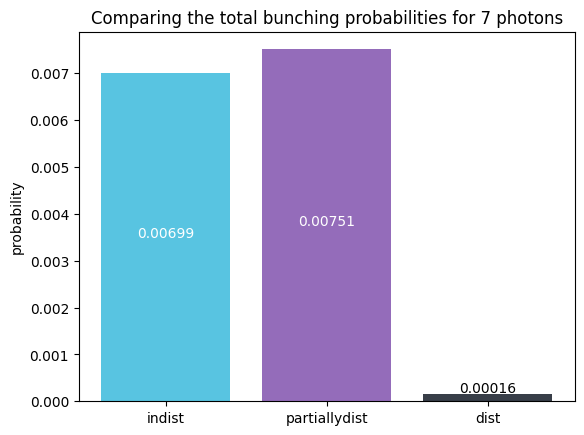

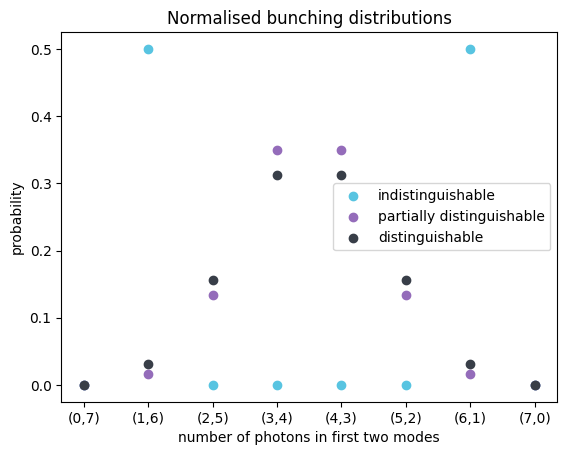

In [8]:
def Plot(n, Probdist_partial , Prob_partial, Probdist_indist , Prob_indist, Probdist_fully , Prob_fully):
    X = []
    for i in range(n+1):
        X.append("({},{})".format(i,n-i)) #creates a list of all possible tuple such that a+b=n for tuple (a,b)
    outputmodes = X
    colours= ['#58c4e1','#946cba','#383e48'] # light blue, purple and gray
    def addlabels(x,y):
        for i in range(len(x)):
            if y[i]>0.0005:
                plt.text(i,y[i]/2, round(y[i], 5), ha = 'center', color= 'white')
            else:
                plt.text(i,1.25*y[i], round(y[i], 5), ha = 'center')
    cases = ["indist", "partiallydist", "dist"]
    probabilities = [Prob_indist, Prob_partial, Prob_fully]
    plt.bar(cases, probabilities, color= colours)
    plt.ylabel('probability')
    plt.title("Comparing the total bunching probabilities for {} photons".format(n))
    addlabels(cases, probabilities)
    plt.show()
    
    plt.scatter(outputmodes,Probdist_indist, label = 'indistinguishable', color = colours[0])
    plt.scatter(outputmodes,Probdist_partial, label = 'partially distinguishable', color= colours[1])
    plt.scatter(outputmodes,Probdist_fully, label= 'distinguishable', color= colours[2])
    plt.ylabel('probability')
    plt.xlabel('number of photons in first two modes')
    plt.title("Normalised bunching distributions")
    plt.legend()
    plt.show()

Plot(n, Probdist_partial , Prob_partial, Probdist_indist , Prob_indist, Probdist_fully , Prob_fully)

To see the that this set up only works for at least 7 photons we can compare the cases of 4,5,6 and 7 photons. You can see this if you run the above for n = 4,5 and 6. Running it for 8 or higher values for n will take a long time.

#### For 8 photons the following holds:

The probability for all 8 indistinguishable photon ending up in the first two modes is: 0.240 %

The probability for all 8 distinguishable photon ending up in the first two modes is: 0.002 %

The probability for all 8 partially distinguishable photon ending up in the first two modes is: 0.294 %


# References

[1] [Hong-Ou-Mandel Interference (2017); Agata M. Branczyk; arXiv:1711.00080](http://arxiv.org/abs/1711.00080)

[2] [Boson bunching is not maximized by indistinguishable particles (2022); Benoit Seron, Leonardo Novo and Nicolas J. Cerf; arXiv:2203.01306](https://arxiv.org/abs/2203.01306)

[3] [Universality of Generalized Bunching and Efficient Assessment of Boson Sampling (2016); V. S. Shchesnovich; arXiv:1509.01561](https://arxiv.org/abs/1509.01561)

[4] [A counterexample to a question of Bapat and Sunder (2016); Stephen W. Drury; Electronic Journal of Linear Algebra **Vol 31** 69-70](https://journals.uwyo.edu/index.php/ela/article/view/1631/1631)
